In [1]:
# CONFIG CELL
from notebook_utils import set_root_directory

set_root_directory()

In [2]:
# IMPORTS
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from app.measurement_ingestor import MeasurementIngestor
from app.constants import TARGET_VARIABLES
import dask.dataframe as dd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import contextily as ctx

In [3]:
# PATH DEFINE
INPUT_DIR = "input_files"
SENSOR_METADATA_PATH = "input_files/sensor_metadata.parquet"

sensor_metadata = pd.read_parquet(SENSOR_METADATA_PATH)

In [4]:
class FlatMeasurementIngestor(MeasurementIngestor):
    def transform(self):
        from collections import defaultdict
        import pandas as pd

        time_1h = defaultdict(list)
        time_24h = defaultdict(list)

        # Get all files in directory
        files = [
            os.path.join(self.input_dir, f)
            for f in os.listdir(self.input_dir)
            if f.endswith((".xlsx", ".xls", ".parquet")) and "sensor_metadata" not in f
        ]

        for file in files:
            file_name = os.path.basename(file)

            try:
                # Handle different file types
                if file.endswith(".parquet"):
                    df = pd.read_parquet(file)
                elif file.endswith((".xlsx", ".xls")):
                    # Explicitly specify engine for Excel files
                    df = pd.read_excel(file, engine="openpyxl")  # or 'xlrd'

                # Add your processing logic here
                if "1h" in file_name.lower():
                    time_1h[file_name].append(df)
                elif "24h" in file_name.lower():
                    time_24h[file_name].append(df)

            except Exception as e:
                print(f"Error processing {file_name}: {str(e)}")
                continue

        # Convert dictionaries to DataFrames
        def concat_dict(d):
            if not d:
                return pd.DataFrame()
            return pd.concat([pd.concat(df_list) for df_list in d.values()])

        return concat_dict(time_1h), concat_dict(time_24h)

In [5]:
# LOADING DATA

ingestor = FlatMeasurementIngestor(
    input_dir=INPUT_DIR,
    sensor_metadata=sensor_metadata,
    exclude_depoyzcja=True,
    target_variables=TARGET_VARIABLES,
)


time_1h_df, time_24h_df = ingestor.transform()

# Now these will be DataFrames with proper columns
print("Columns in time_1h_df:", time_1h_df.columns.tolist())
print("Columns in time_24h_df:", time_24h_df.columns.tolist())

Columns in time_1h_df: ['ds', 'unique_id', 'NO2', 'NOx', 'O3', 'SO2', 'C6H6', 'CO', 'PM10', 'PM2.5', 'NO']
Columns in time_24h_df: ['ds', 'unique_id', 'PM10', 'NO2', 'SO2', 'C6H6', 'PM2.5', 'prediction', 'prediction-lo-68', 'prediction-hi-68']


In [6]:
time_1h_df

ds  unique_id  NO2  NOx    O3  SO2  C6H6  CO  PM10  \
0        2000-01-01 01:00:00         10  NaN  NaN   NaN  NaN   NaN NaN   NaN   
1        2000-01-01 02:00:00         10  6.0  7.0  35.0  NaN   NaN NaN   NaN   
2        2000-01-01 03:00:00         10  3.0  3.0  42.0  NaN   NaN NaN   NaN   
3        2000-01-01 04:00:00         10  4.0  4.0  39.0  NaN   NaN NaN   NaN   
4        2000-01-01 05:00:00         10  3.0  3.0  44.0  NaN   NaN NaN   NaN   
...                      ...        ...  ...  ...   ...  ...   ...  ..   ...   
97197403 2023-12-31 20:00:00       1098  NaN  NaN   NaN  NaN   NaN NaN   NaN   
97197404 2023-12-31 21:00:00       1098  NaN  NaN   NaN  NaN   NaN NaN   NaN   
97197405 2023-12-31 22:00:00       1098  NaN  NaN   NaN  NaN   NaN NaN   NaN   
97197406 2023-12-31 23:00:00       1098  NaN  NaN   NaN  NaN   NaN NaN   NaN   
97197407 2024-01-01 00:00:00       1098  NaN  NaN   NaN  NaN   NaN NaN   NaN   

          PM2.5  NO  
0           NaN NaN  
1           NaN NaN  
2           NaN NaN  
3           NaN NaN  
4           NaN NaN  
...         ...  ..  
97197403    NaN NaN  
97197404    NaN NaN  
97197405    NaN NaN  
97197406    NaN NaN  
97197407    NaN NaN  

[97197408 rows x 11 columns]

In [7]:
# BASIC STATISTICS


def basic_stats(df, name):
    print(f"\n=== BASIC STATISTICS - {name} ===")
    print(f"Number of rows: {len(df)}")

    # Handle datetime column
    if "ds" in df.columns:
        print(f"Date range: {df['ds'].min()} - {df['ds'].max()}")
    elif "timestamp" in df.columns:
        print(f"Date range: {df['timestamp'].min()} - {df['timestamp'].max()}")

    # Handle ID column
    if "unique_id" in df.columns:
        print(f"Unique sensors count: {df['unique_id'].nunique()}")

    # Numeric statistics
    numeric_cols = df.select_dtypes(include=["number"]).columns
    if not numeric_cols.empty:
        print("\nDescriptive statistics for numeric columns:")
        print(df[numeric_cols].describe())
    else:
        print("\nNo numeric columns found")

    # Categorical statistics (only if such columns exist)
    categorical_cols = df.select_dtypes(include=["object", "category"]).columns
    if not categorical_cols.empty:
        print("\nDescriptive statistics for categorical columns:")
        print(df[categorical_cols].describe())

    # Column types summary
    print("\nColumn types summary:")
    print(df.dtypes.value_counts())

In [8]:
basic_stats(time_1h_df, "Dane 1-godzinne")
basic_stats(time_24h_df, "Dane 24-godzinne")


=== BASIC STATISTICS - Dane 1-godzinne ===
Number of rows: 97197408
Date range: 2000-01-01 01:00:00 - 2024-01-01 00:00:00
Unique sensors count: 462

Descriptive statistics for numeric columns:
          unique_id           NO2           NOx            O3           SO2  \
count  9.719741e+07  2.146812e+07  2.085802e+07  1.380542e+07  1.911445e+07   
mean   5.458874e+02  1.773697e+01  2.972659e+01  5.019842e+01  7.623290e+00   
std    3.235175e+02  1.647957e+01  4.905571e+01  2.944795e+01  1.174727e+01   
min    1.000000e+00 -2.404340e+00 -1.600000e+00 -1.057220e+00 -5.000000e+00   
25%    2.420000e+02  6.900000e+00  8.200000e+00  2.800000e+01  2.000660e+00   
50%    5.355000e+02  1.271820e+01  1.550000e+01  4.830000e+01  4.115750e+00   
75%    8.350000e+02  2.300000e+01  3.050000e+01  6.939440e+01  8.500000e+00   
max    1.116000e+03  5.340000e+02  1.877000e+03  5.330000e+02  1.294000e+03   

               C6H6            CO          PM10         PM2.5            NO  
count  5.456655e


=== MISSING DATA ANALYSIS - 1h ===
       Missing Values  % of Total
PM2.5        92975382       95.66
C6H6         91740753       94.39
NO           91256837       93.89
CO           86087211       88.57
O3           83391985       85.80
PM10         78803295       81.08
SO2          78082958       80.33
NOx          76339392       78.54
NO2          75729292       77.91

Visualizing missing data pattern (sample of 100000 rows)...


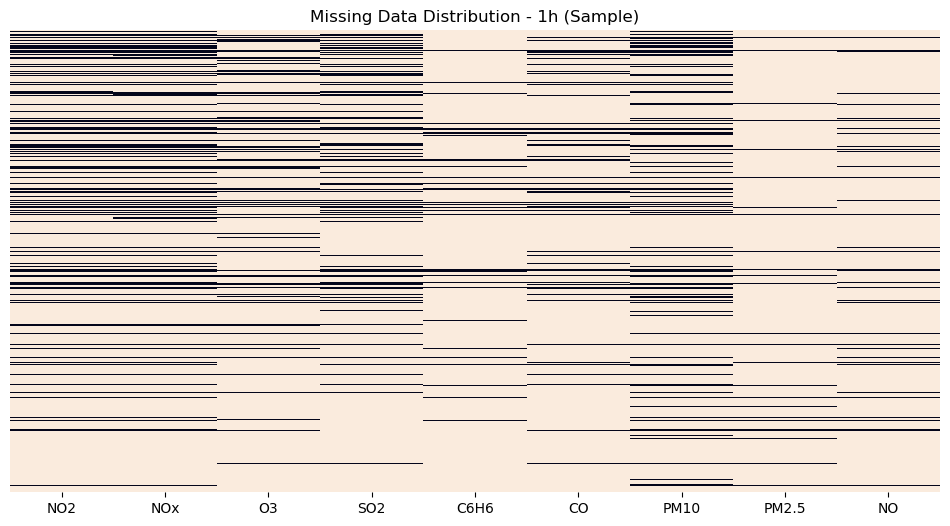


Additional Metrics:
Total rows analyzed: 97,197,408
Columns with >50% missing: 9
Most complete column: NO2 (77.91% missing)
Least complete column: PM2.5 (95.66% missing)

=== MISSING DATA ANALYSIS - 24h ===
                  Missing Values  % of Total
prediction               8956314      100.00
prediction-lo-68         8956314      100.00
prediction-hi-68         8956314      100.00
C6H6                     8918729       99.58
PM2.5                    8780927       98.04
NO2                      8554974       95.52
SO2                      8543712       95.39
PM10                     6693348       74.73

Visualizing missing data pattern (sample of 100000 rows)...


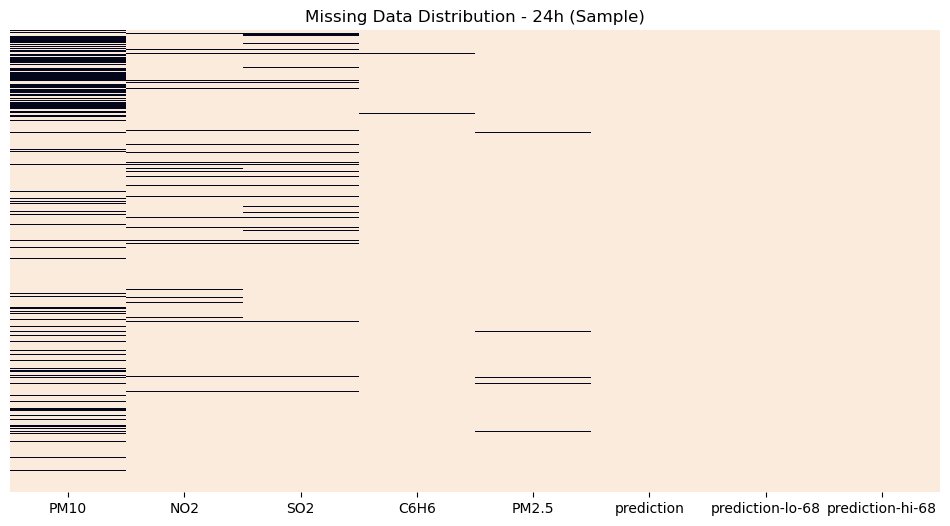


Additional Metrics:
Total rows analyzed: 8,956,384
Columns with >50% missing: 8
Most complete column: PM10 (74.73% missing)
Least complete column: prediction (100.00% missing)


In [9]:
def missing_data_analysis_dask(dask_df, name, sample_size=100000):
    """
    Optimized missing data analysis for large datasets using Dask
    Skips 'ds' and 'unique_id' columns in analysis

    Parameters:
    - dask_df: Dask DataFrame
    - name: Analysis name for display
    - sample_size: Number of rows to sample for visualization
    """
    print(f"\n=== MISSING DATA ANALYSIS - {name} ===")

    # 1. Exclude timestamp and ID columns from analysis
    cols_to_analyze = [col for col in dask_df.columns if col not in ["ds", "unique_id"]]
    analysis_df = dask_df[cols_to_analyze]

    # 2. Calculate missing values statistics
    missing = analysis_df.isnull().sum().compute()
    missing_percent = (missing / len(analysis_df)) * 100

    # Create and display results
    missing_df = pd.DataFrame(
        {"Missing Values": missing, "% of Total": missing_percent.round(2)}
    ).sort_values("Missing Values", ascending=False)

    print(missing_df)

    # 3. Visualization using a sample
    print(f"\nVisualizing missing data pattern (sample of {sample_size} rows)...")

    # Take a sample for visualization (excluding timestamp/id columns)
    sample_df = analysis_df.sample(frac=sample_size / len(analysis_df)).compute()

    plt.figure(figsize=(12, 6))
    sns.heatmap(sample_df.isnull(), cbar=False, yticklabels=False)
    plt.title(f"Missing Data Distribution - {name} (Sample)")
    plt.show()

    # 4. Additional metrics
    print("\nAdditional Metrics:")
    print(f"Total rows analyzed: {len(analysis_df):,}")
    print(f"Columns with >50% missing: {sum(missing_percent > 50)}")
    print(
        f"Most complete column: {missing_percent.idxmin()} ({missing_percent.min():.2f}% missing)"
    )
    print(
        f"Least complete column: {missing_percent.idxmax()} ({missing_percent.max():.2f}% missing)"
    )


# Usage example:
dask_time_1h = dd.from_pandas(time_1h_df, npartitions=10)
dask_time_24h = dd.from_pandas(time_24h_df, npartitions=10)

missing_data_analysis_dask(dask_time_1h, "1h")
missing_data_analysis_dask(dask_time_24h, "24h")


Starting analysis for 1-hour data...

=== TIME SERIES ANALYSIS - 1-hour data (Dask) ===

Sampling 100000 rows for visualization...
[########################################] | 100% Completed | 101.72 ms
[########################################] | 100% Completed | 12.05 s

Calculating monthly averages...
[########################################] | 100% Completed | 3.53 sms

Calculating hourly averages...
[########################################] | 100% Completed | 1.93 sms

Calculating daily trends...
[########################################] | 100% Completed | 16.96 s


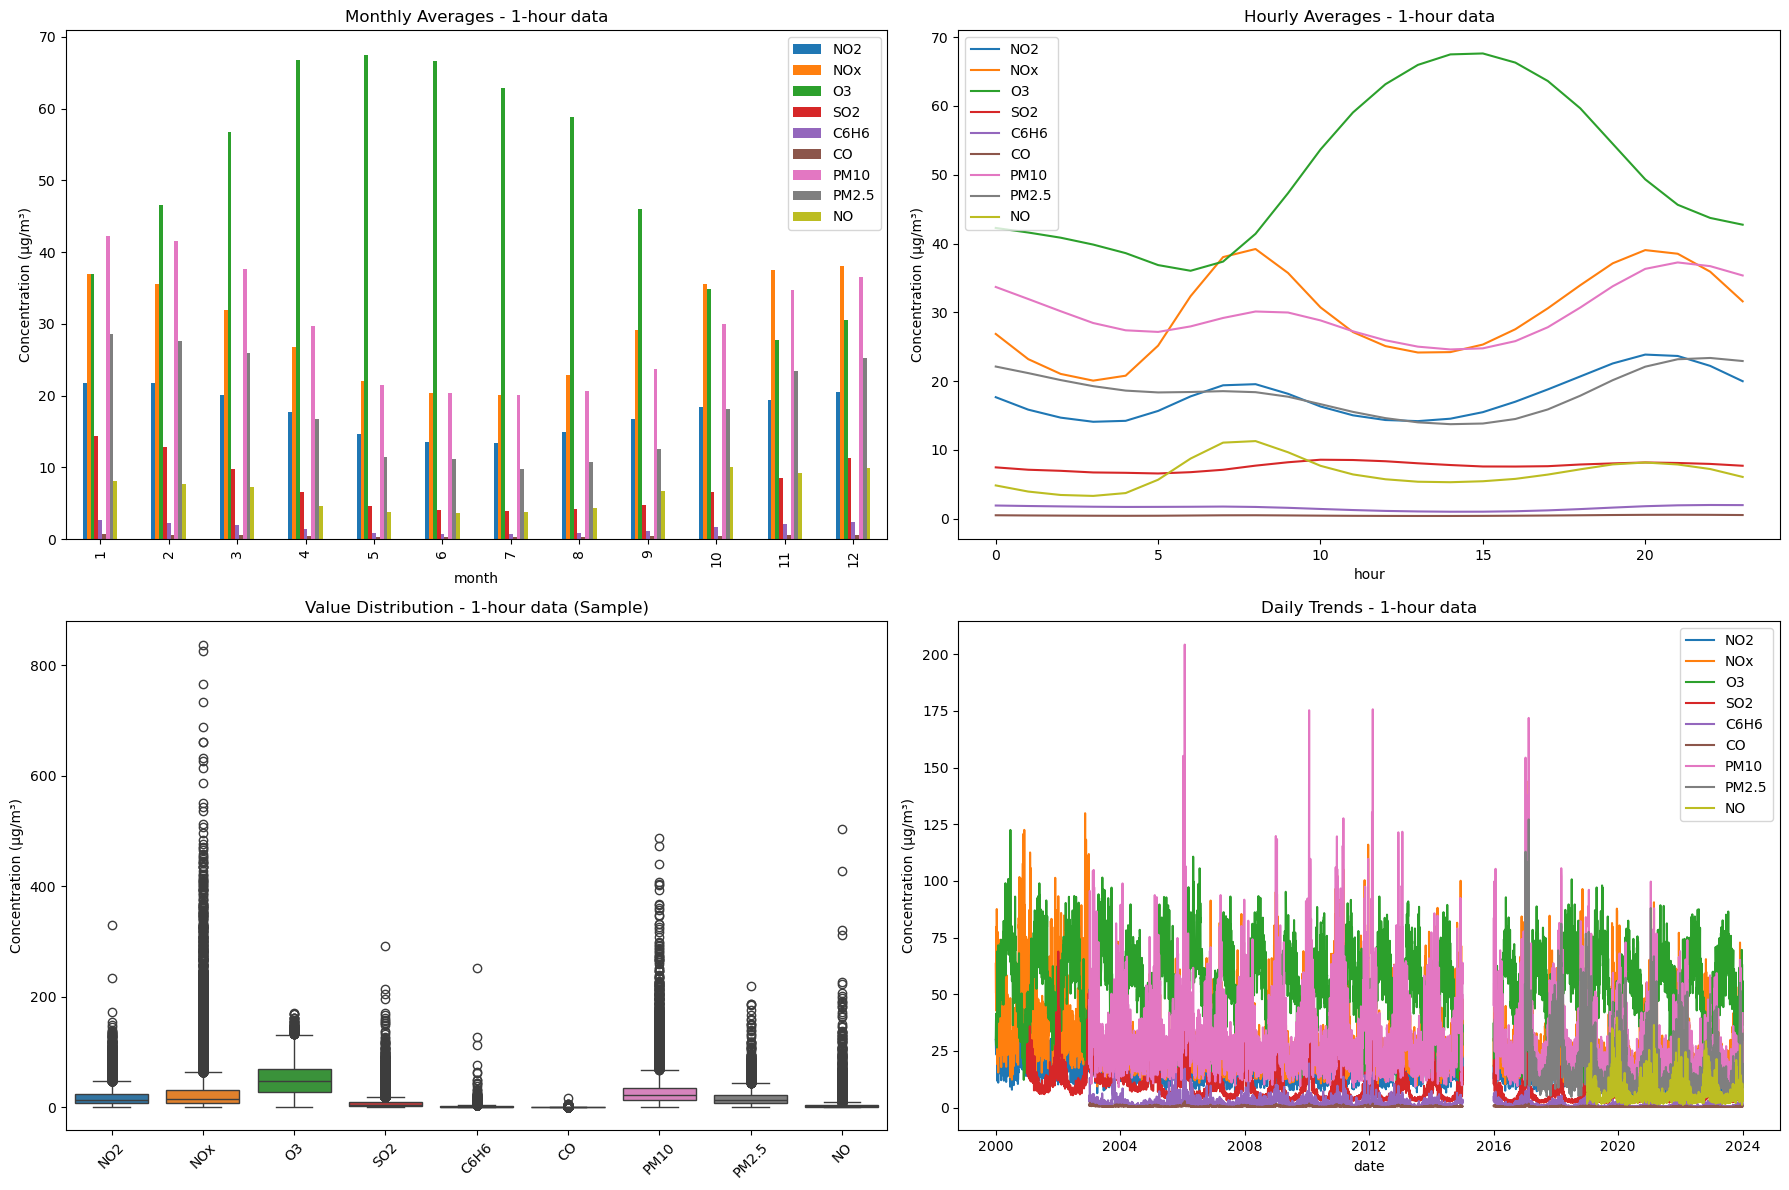


Starting analysis for 24-hour data...

=== TIME SERIES ANALYSIS - 24-hour data (Dask) ===

Sampling 100000 rows for visualization...
[########################################] | 100% Completed | 105.12 ms
[########################################] | 100% Completed | 1.24 sms

Calculating monthly averages...
[########################################] | 100% Completed | 205.72 ms

Calculating hourly averages...
[########################################] | 100% Completed | 204.48 ms

Calculating daily trends...
[########################################] | 100% Completed | 1.74 sms


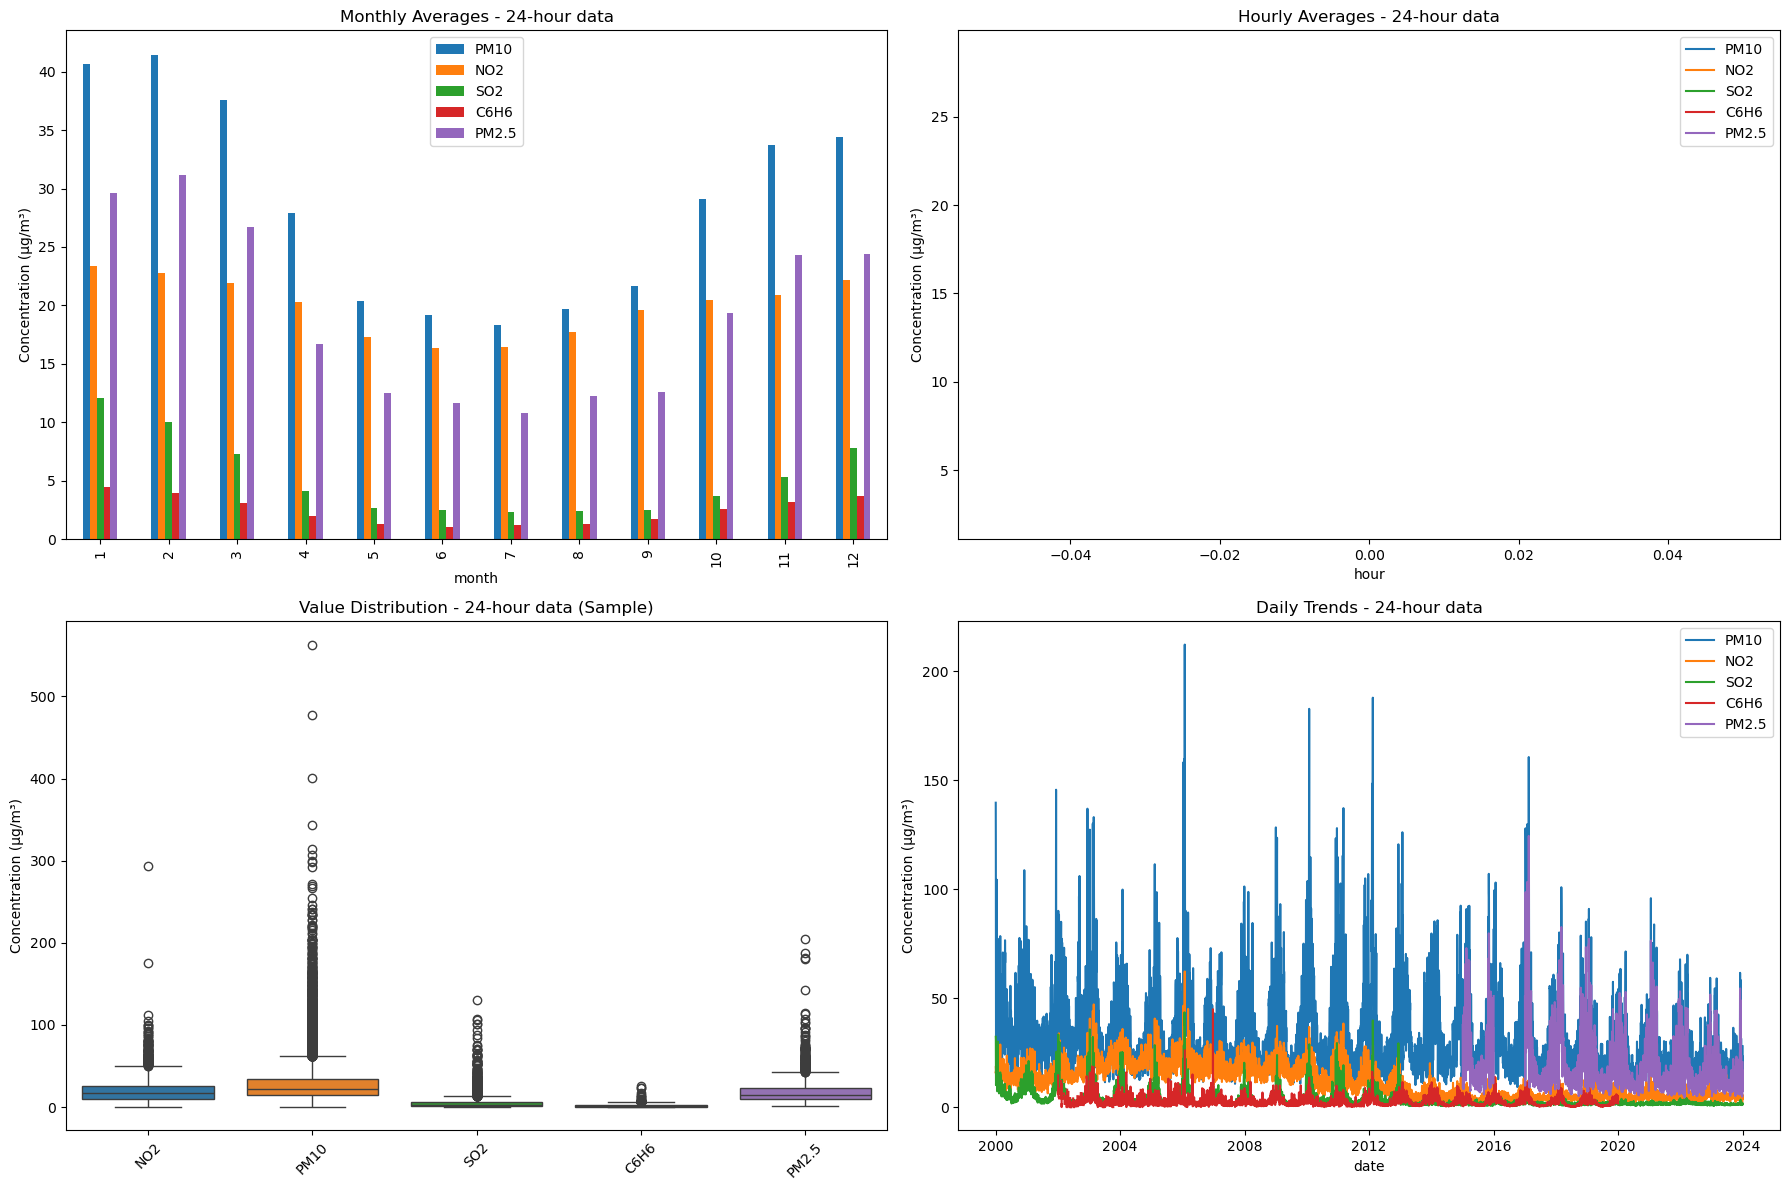

In [10]:
def time_analysis_dask(dask_df, name, target_variables, sample_size=100000):
    """
    Optimized time series analysis using Dask for large datasets

    Parameters:
    - dask_df: Dask DataFrame
    - name: Analysis name
    - target_variables: List of columns to analyze
    - sample_size: Sample size for visualizations
    """
    print(f"\n=== TIME SERIES ANALYSIS - {name} (Dask) ===")

    # Create temporary columns for analysis
    dask_df = dask_df.copy()
    if "ds" in dask_df.columns:
        dask_df["date"] = dask_df["ds"].dt.date
        dask_df["hour"] = dask_df["ds"].dt.hour
        dask_df["month"] = dask_df["ds"].dt.month

    # Take a sample for visualization
    with ProgressBar():
        print(f"\nSampling {sample_size} rows for visualization...")
        df_sample = dask_df.sample(frac=sample_size / len(dask_df)).compute()

    # Visualization
    plt.figure(figsize=(18, 12))

    # 1. Monthly trends (computed in parallel)
    with ProgressBar():
        print("\nCalculating monthly averages...")
        monthly = dask_df.groupby("month")[target_variables].mean().compute()

    plt.subplot(2, 2, 1)
    monthly.plot(kind="bar", ax=plt.gca())
    plt.title(f"Monthly Averages - {name}")
    plt.ylabel("Concentration (µg/m³)")

    # 2. Hourly trends (computed in parallel)
    with ProgressBar():
        print("\nCalculating hourly averages...")
        hourly = dask_df.groupby("hour")[target_variables].mean().compute()

    plt.subplot(2, 2, 2)
    hourly.plot(kind="line", ax=plt.gca())
    plt.title(f"Hourly Averages - {name}")
    plt.ylabel("Concentration (µg/m³)")

    # 3. Boxplots (on sample)
    plt.subplot(2, 2, 3)
    sns.boxplot(data=df_sample[target_variables])
    plt.title(f"Value Distribution - {name} (Sample)")
    plt.xticks(rotation=45)
    plt.ylabel("Concentration (µg/m³)")

    # 4. Daily trends (computed in parallel)
    with ProgressBar():
        print("\nCalculating daily trends...")
        daily = dask_df.groupby("date")[target_variables].mean().compute()

    plt.subplot(2, 2, 4)
    daily.plot(ax=plt.gca())
    plt.title(f"Daily Trends - {name}")
    plt.ylabel("Concentration (µg/m³)")

    plt.tight_layout()
    plt.show()

    return dask_df.drop(["date", "hour", "month"], axis=1)


# Convert to Dask DataFrames
dask_time_1h = dd.from_pandas(time_1h_df, npartitions=10)
dask_time_24h = dd.from_pandas(time_24h_df, npartitions=10)

# Define target variables
TARGET_1H = ["NO2", "NOx", "O3", "SO2", "C6H6", "CO", "PM10", "PM2.5", "NO"]
TARGET_24H = ["NO2", "PM10", "SO2", "C6H6", "PM2.5"]

# Execute analysis
print("\nStarting analysis for 1-hour data...")
dask_time_1h = time_analysis_dask(dask_time_1h, "1-hour data", TARGET_1H)

print("\nStarting analysis for 24-hour data...")
dask_time_24h = time_analysis_dask(dask_time_24h, "24-hour data", TARGET_24H)

In [22]:
# SPATIAL ANALYSIS
def spatial_analysis_dask(dask_df, sensor_metadata, target_var="PM2.5", sample_size=1000):
    """
    Spatial analysis with Dask optimization and Poland map background

    Parameters:
    - dask_df: Dask DataFrame with measurement data
    - sensor_metadata: Pandas DataFrame with sensor locations
    - target_var: Variable to visualize (default: PM2.5)
    - sample_size: Number of points to sample for visualization
    """
    sensor_metadata = sensor_metadata.copy()
    dask_df = dask_df.copy()

    if not all(col in sensor_metadata.columns for col in ["latitude", "longitude"]):
        print("Skipping spatial analysis - missing coordinates")
        return

    print("\n=== SPATIAL ANALYSIS WITH POLAND MAP (Dask) ===")

    with ProgressBar():
        # Merge with metadata
        sensor_metadata["sensor_id"] = sensor_metadata["sensor_id"].astype(str)
        dask_df["unique_id"] = dask_df["unique_id"].astype(str)
        merged = dd.merge(
            dask_df[["unique_id", target_var]],
            sensor_metadata[["sensor_id", "latitude", "longitude"]],
            left_on="unique_id",
            right_on="sensor_id",
        ).compute()

        sample = merged.sample(min(sample_size, len(merged)))

    # Create figure and axis
    plt.figure(figsize=(14, 10))
    ax = plt.gca()

    # Calculate plot boundaries (Poland approximate coordinates)
    min_lon, max_lon = 14.0, 24.5
    min_lat, max_lat = 49.0, 55.0

    # Filter points within Poland boundaries
    sample = sample[
        (sample["longitude"].between(min_lon, max_lon))
        & (sample["latitude"].between(min_lat, max_lat))
    ]

    # Create scatter plot
    scatter = ax.scatter(
        x=sample["longitude"],
        y=sample["latitude"],
        c=sample[target_var],
        s=sample[target_var].rank(pct=True) * 100 + 20,
        alpha=0.7,
        cmap="viridis",
        edgecolors="w",
        linewidths=0.5,
    )

    # Add map background
    ctx.add_basemap(
        ax,
        crs="EPSG:4326",  # WGS84 coordinate system
        source=ctx.providers.OpenStreetMap.Mapnik,
        zoom=7,
    )

    # Customize plot
    plt.title(f"{target_var} Spatial Distribution in Poland (Sample)", fontsize=14, pad=20)
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.7)
    cbar.set_label(f"{target_var} Concentration (µg/m³)", fontsize=12)

    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)
    ax.set_xlim(min_lon, max_lon)
    ax.set_ylim(min_lat, max_lat)

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [23]:
# CORRELATION ANALYSIS


def correlation_analysis_dask(dask_df, name, target_variables):
    """
    Correlation analysis with Dask optimization

    Parameters:
    - dask_df: Dask DataFrame
    - name: Analysis name
    - target_variables: List of columns for correlation
    """
    print(f"\n=== CORRELATION ANALYSIS - {name} (Dask) ===")

    with ProgressBar():
        # Compute correlation matrix in parallel
        corr_matrix = dask_df[target_variables].corr().compute()

    plt.figure(figsize=(12, 8))
    sns.heatmap(
        corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, vmin=-1, vmax=1, square=True
    )
    plt.title(f"Correlation Matrix - {name}")
    plt.tight_layout()
    plt.show()


=== SPATIAL ANALYSIS WITH POLAND MAP (Dask) ===


c:\Users\Mambo\.conda\envs\ispies\Lib\site-packages\dask\dataframe\multi.py:169: UserWarning: Merging dataframes with merge column data type mismatches: 
+----------------------------+------------+-------------+
| Merge columns              | left dtype | right dtype |
+----------------------------+------------+-------------+
| ('unique_id', 'sensor_id') | object     | string      |
+----------------------------+------------+-------------+
Cast dtypes explicitly to avoid unexpected results.
  warnings.warn(


[########################################] | 100% Completed | 21.19 s


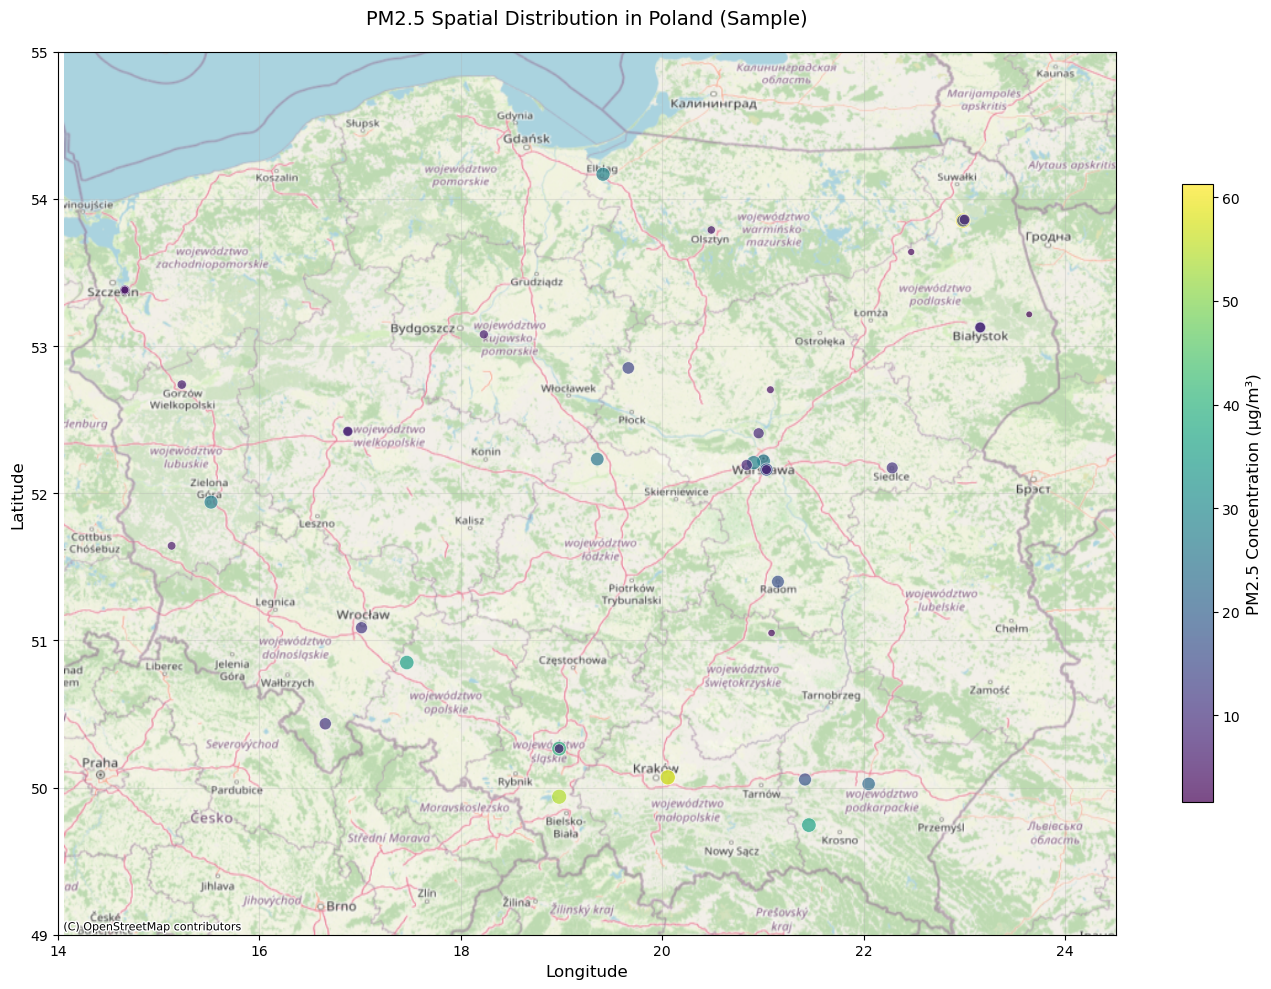


=== SPATIAL ANALYSIS WITH POLAND MAP (Dask) ===


c:\Users\Mambo\.conda\envs\ispies\Lib\site-packages\dask\dataframe\multi.py:169: UserWarning: Merging dataframes with merge column data type mismatches: 
+----------------------------+------------+-------------+
| Merge columns              | left dtype | right dtype |
+----------------------------+------------+-------------+
| ('unique_id', 'sensor_id') | object     | string      |
+----------------------------+------------+-------------+
Cast dtypes explicitly to avoid unexpected results.
  warnings.warn(


[########################################] | 100% Completed | 2.17 sms


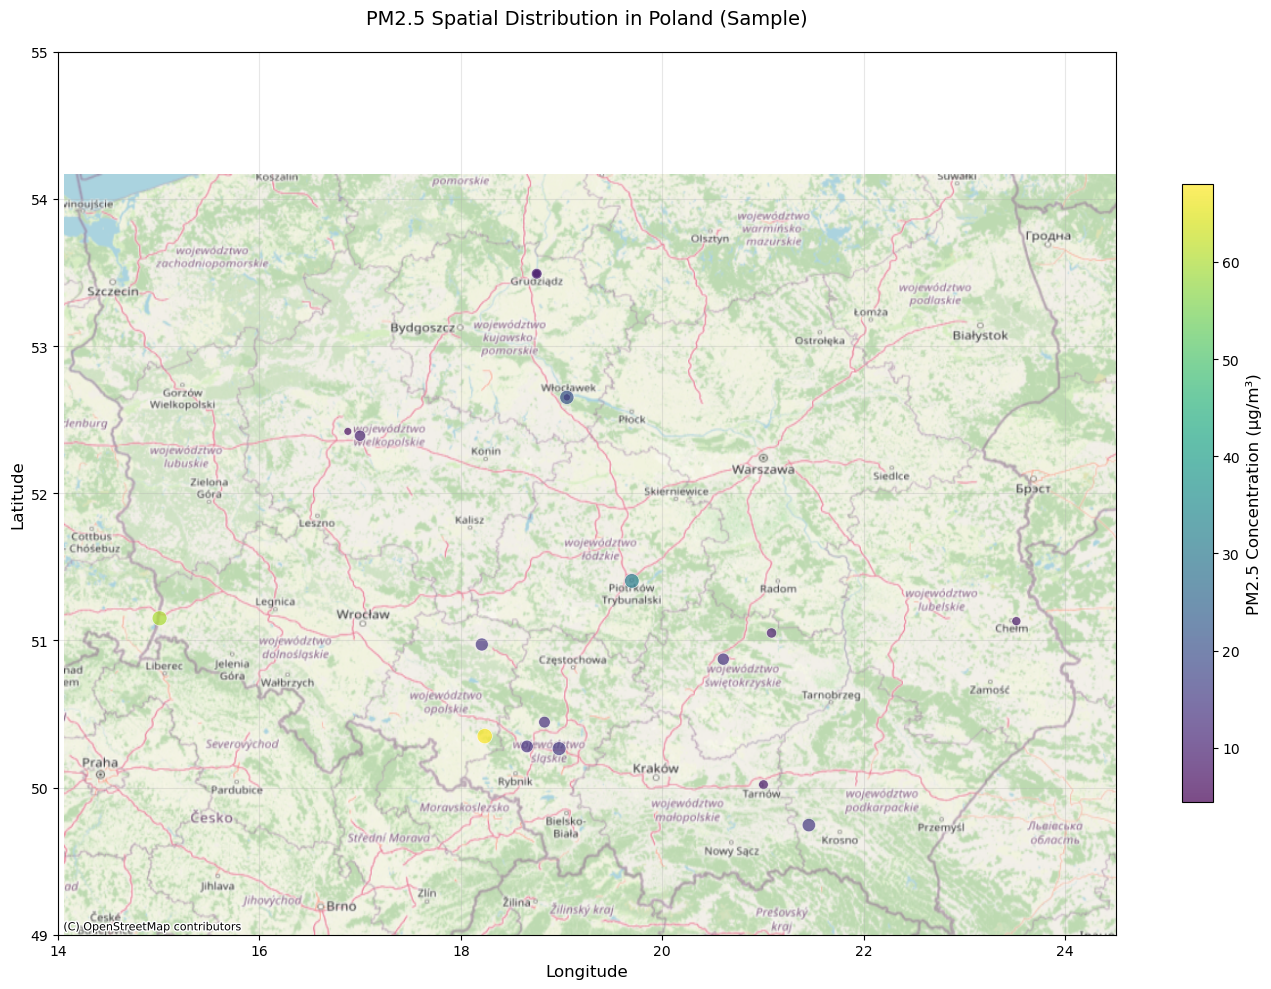


=== CORRELATION ANALYSIS - 1h (Dask) ===
[########################################] | 100% Completed | 22.90 s


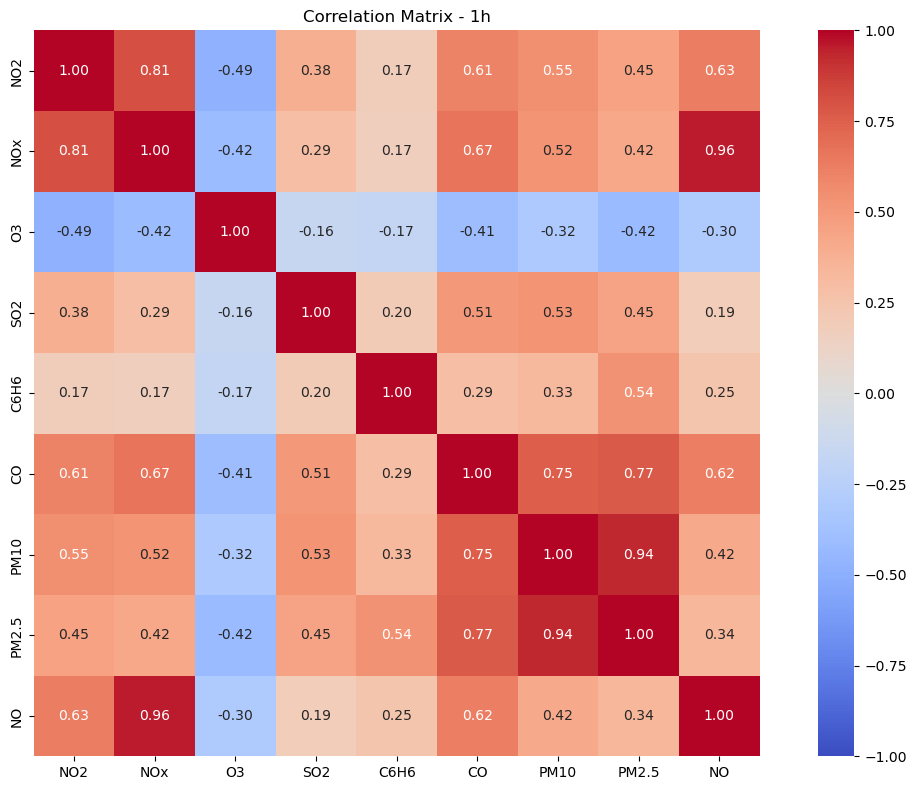


=== CORRELATION ANALYSIS - 24h (Dask) ===
[########################################] | 100% Completed | 814.69 ms


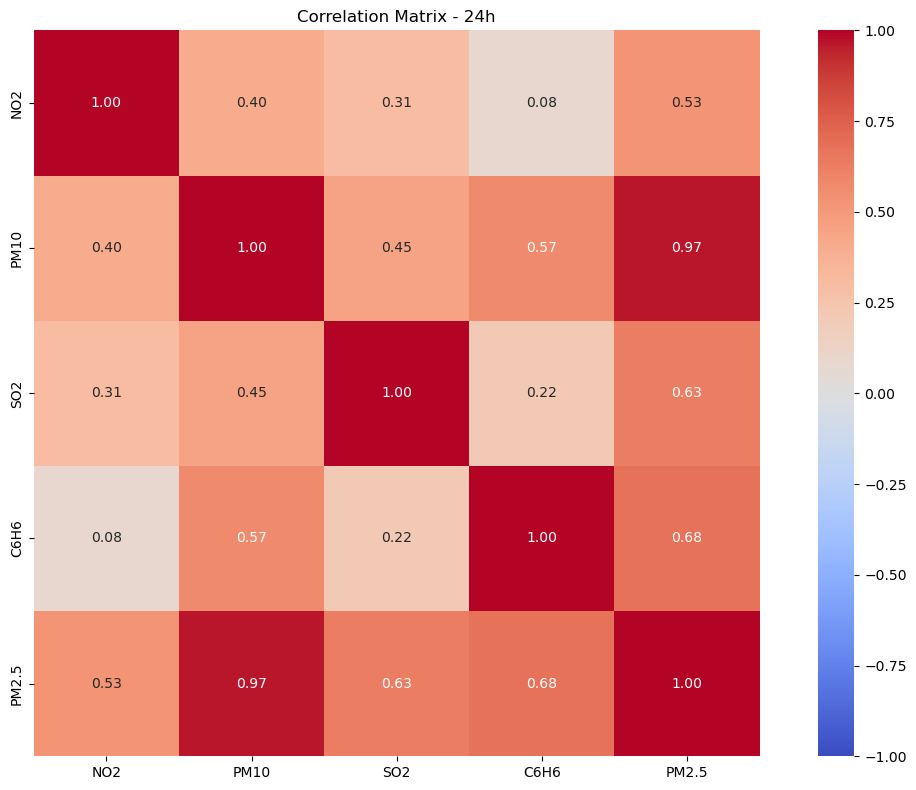

In [24]:
spatial_analysis_dask(dask_time_1h, sensor_metadata, "PM2.5")
spatial_analysis_dask(dask_time_24h, sensor_metadata, "PM2.5")

correlation_analysis_dask(dask_time_1h, "1h", TARGET_1H)
correlation_analysis_dask(dask_time_24h, "24h", TARGET_24H)


=== OUTLIER ANALYSIS - 1-hour data (Dask) ===
[########################################] | 100% Completed | 6.13 sms

Extreme Value Statistics:


NO2     NOx         O3     SO2       C6H6         CO         PM10  \
min   -2.404340    -1.6   -1.05722    -5.0   -0.05000  -0.107860    -6.000000   
1%     1.586367     2.2    2.10000     0.5    0.07072   0.157688     3.380894   
99%   88.500000   325.0  131.00000    65.6   23.80000   2.173000   188.760000   
max  534.000000  1877.0  533.00000  1294.0  798.00000  16.860000  2047.000000   

          PM2.5          NO  
min   -3.352276   -9.564340  
1%     2.471120    0.110269  
99%  119.086260  134.209580  
max  644.200000  955.161000

[########################################] | 100% Completed | 655.87 ms
[########################################] | 100% Completed | 698.82 ms
[########################################] | 100% Completed | 102.69 ms
[########################################] | 100% Completed | 102.32 ms
[########################################] | 100% Completed | 102.47 ms
[########################################] | 100% Completed | 102.32 ms
[########################################] | 100% Completed | 102.99 ms
[########################################] | 100% Completed | 102.34 ms
[########################################] | 100% Completed | 102.91 ms
[########################################] | 100% Completed | 102.29 ms
[########################################] | 100% Completed | 102.24 ms

IQR-based Outlier Counts (1.5*IQR rule):


Outlier Count  % of Total
NO2          1002567        1.03
NOx          1698707        1.75
O3             54763        0.06
SO2          1097371        1.13
C6H6          309497        0.32
CO            552334        0.57
PM10         1062389        1.09
PM2.5         232513        0.24
NO            679708        0.70

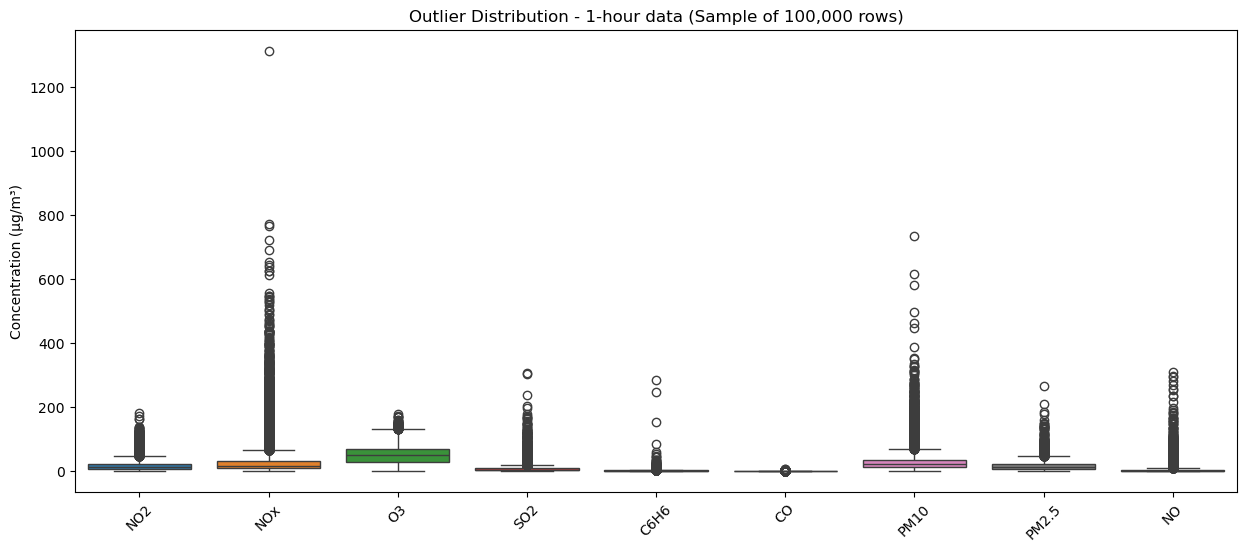


=== OUTLIER ANALYSIS - 24-hour data (Dask) ===
[########################################] | 100% Completed | 413.62 ms

Extreme Value Statistics:


NO2      PM10    SO2   C6H6    PM2.5
min    0.0     0.000    0.0   0.00    0.000
1%     3.0     6.400    0.4   1.00    6.148
99%   87.0   164.189   51.0  20.00  105.450
max  293.0  1098.000  369.0  84.94  292.000

[########################################] | 100% Completed | 104.03 ms
[########################################] | 100% Completed | 103.40 ms
[########################################] | 100% Completed | 102.94 ms
[########################################] | 100% Completed | 102.67 ms
[########################################] | 100% Completed | 102.49 ms
[########################################] | 100% Completed | 102.64 ms
[########################################] | 100% Completed | 102.54 ms

IQR-based Outlier Counts (1.5*IQR rule):


Outlier Count  % of Total
NO2             8461        0.09
PM10           81704        0.91
SO2            29130        0.33
C6H6            2053        0.02
PM2.5           6863        0.08

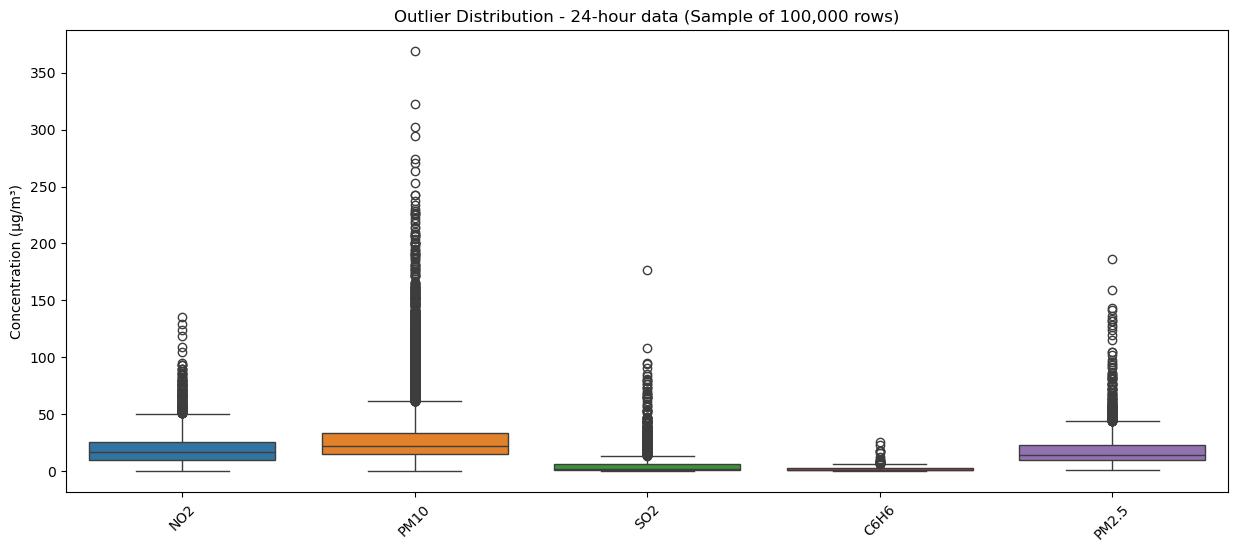

In [25]:
# OUTLIER ANALYSIS
def outlier_analysis_dask(dask_df, name, target_variables, n_partitions=10):
    """
    Outlier analysis using Dask with boxplots and statistical summary

    Parameters:
    - dask_df: Dask DataFrame
    - name: Analysis name
    - target_variables: List of columns to analyze
    - n_partitions: Number of partitions for Dask
    """
    print(f"\n=== OUTLIER ANALYSIS - {name} (Dask) ===")

    # Convert to Dask if not already
    if not isinstance(dask_df, dd.DataFrame):
        dask_df = dd.from_pandas(dask_df, npartitions=n_partitions)

    # Calculate basic statistics in parallel
    with ProgressBar():
        stats = dask_df[target_variables].describe(percentiles=[0.01, 0.99]).compute()

    print("\nExtreme Value Statistics:")
    display(stats.loc[["min", "1%", "99%", "max"]])

    # Calculate IQR-based outliers in parallel
    with ProgressBar():
        q1 = dask_df[target_variables].quantile(0.25).compute()
        q3 = dask_df[target_variables].quantile(0.75).compute()
        iqr = q3 - q1

        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        outlier_counts = {}
        for col in target_variables:
            outliers = (
                dask_df[(dask_df[col] < lower_bound[col]) | (dask_df[col] > upper_bound[col])][col]
                .count()
                .compute()
            )
            outlier_counts[col] = outliers

    print("\nIQR-based Outlier Counts (1.5*IQR rule):")
    outlier_df = pd.DataFrame.from_dict(outlier_counts, orient="index", columns=["Outlier Count"])
    outlier_df["% of Total"] = (outlier_df["Outlier Count"] / len(dask_df)) * 100
    display(outlier_df.round(2))

    # Sample data for visualization
    sample_size = min(100000, len(dask_df) // 10)
    sample_df = dask_df.sample(frac=sample_size / len(dask_df)).compute()

    # Visualization
    plt.figure(figsize=(15, 6))
    sns.boxplot(data=sample_df[target_variables])
    plt.title(f"Outlier Distribution - {name} (Sample of {sample_size:,} rows)")
    plt.xticks(rotation=45)
    plt.ylabel("Concentration (µg/m³)")
    plt.show()

    return {
        "stats": stats,
        "outlier_counts": outlier_df,
        "iqr_bounds": pd.DataFrame({"lower": lower_bound, "upper": upper_bound}),
    }


outlier_results_1h = outlier_analysis_dask(dask_time_1h, "1-hour data", TARGET_1H)


outlier_results_24h = outlier_analysis_dask(dask_time_24h, "24-hour data", TARGET_24H)